In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import os
from owi_data_2_pandas.io import API
import datetime
from pytz import utc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Import vub Meetenet Vlaamse Banken API functions
from vubmvbc.config import Credentials
from vubmvbc.client import Base
from vubmvbc.objects import Catalog, Data
import vubmvbc.data_getter as dg

from oma_tracking.oma_clustering import ModeClusterer  #pip install hdbscan --no-build-isolation --no-binary :all
from oma_tracking.data.make_dataset import DatasetGetter

In [47]:
user = os.getenv('API_USERNAME') 
password = os.getenv('API_PASSWORD')
root = r"http://10.0.0.138/api/v1/"
owi = API(api_root=root, username=user, password=password)

In [48]:
owi.groups.iloc[2]

project                         parkwind
locations                        [bbc01]
datagroups    [acceleration, mpe, scada]
Name: 3, dtype: object

In [52]:
start  = datetime.datetime(2012,1,1,tzinfo=utc)
stop  = datetime.datetime(2023,7,19,tzinfo=utc)

location = 'bbc01'
name_location = 'BB_C01'

dsg = DatasetGetter(start, stop, location)
dsg.get_longterm_data()

In [53]:
home_folder = "../../"
# Data Paths
data_file_name = '_'.join([location, start.strftime("%Y%m%d"), stop.strftime("%Y%m%d")])
data_path = home_folder + "data/bb/raw/" + data_file_name + ".parquet"
dsg.save_data(data_path)

In [54]:
mvbc_username = os.getenv('MEETNET_USERNAME') # Replace with your usernam
mvbc_password = os.getenv('MEETNET_PASSWORD') # Replace with your password
creds = Credentials(username=mvbc_username, password=mvbc_password)
b=Base(creds)
b.ping()

c = Catalog(credentials=creds)
df_unfiltered = c.data_points()

In [65]:
weather_station = 'Wandelaar'
weather_station_data = \
    dg.get_data_by_weatherstation(
        weather_station,
        start,
        stop,
        creds,
        df_unfiltered
    )
weather_station_data = weather_station_data.resample('10T', axis=0).interpolate(method='linear', axis=0, limit=12)

In [94]:
# Make a column that combines sea water temperature measurements of Pile and Buoy
Sea_water_temp = pd.concat([
    weather_station_data['mvbc_WandelaarMeasuringpile_Sea_water_temperature'].dropna(),
    weather_station_data['mvbc_WandelaarBuoy_Sea_water_temperature'].dropna()
    ], axis=0)
Sea_water_temp = Sea_water_temp.resample('10T', axis=0).interpolate(method='linear', axis=0, limit=12)
weather_station_data['mvbc_Wandelaar_Sea_water_temperature_'] = Sea_water_temp

In [83]:
weather_data_path = "../../data/nw2/Wandelaar_data_longterm.parquet"
weather_station_data.to_parquet(weather_data_path, compression='gzip')

In [73]:
weather_station = 'Westhinder'
Westhinder_data = \
    dg.get_data_by_weatherstation(
        weather_station,
        start,
        stop,
        creds,
        df_unfiltered
    )
Westhinder_data = Westhinder_data.resample('10T', axis=0).interpolate(method='linear', axis=0, limit=12)

In [81]:
Westhinder_data_path = "../../data/nw2/Westhinder_data_longterm.parquet"
Westhinder_data.to_parquet(Westhinder_data_path, compression='gzip')

In [75]:
Westhinder_data.isna().sum()

mvbc_WesthinderBuoy_10%_highest_waves                                     22022
mvbc_WesthinderBuoy_Wave_height                                           22022
mvbc_WesthinderBuoy_Average_wave_period                                   22022
mvbc_WesthinderBuoy_Height_waves_with_period_>_10_s                       22044
mvbc_WesthinderBuoy_High_frequent_wave_direction                          23722
mvbc_WesthinderBuoy_Low_frequent_wave_direction                           23726
mvbc_WesthinderMeasuringpile_Sea_water_temperature                        76766
mvbc_WesthinderBuoy_Sea_water_temperature                                 84796
mvbc_WesthinderMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)     28884
mvbc_WesthinderMeasuringpile_Average_wind_direction                       29511
mvbc_WesthinderMeasuringpile_Average_wind_speed_(at_10_m_height)          30021
mvbc_WesthinderMeasuringpile_Tide_TAW                                     27726
mvbc_WesthinderMeasuringpile_Air_pressur

In [72]:
weather_station = 'Thorntonbank'
Thorntonbank_data = \
    dg.get_data_by_weatherstation(
        weather_station,
        start,
        stop,
        creds,
        df_unfiltered
    )
Thorntonbank_data = Thorntonbank_data.resample('10T', axis=0).interpolate(method='linear', axis=0, limit=12)

In [82]:
Thorntonbank_data_path = "../../data/nw2/Thorntonbank_data_longterm.parquet"
Thorntonbank_data.to_parquet(Thorntonbank_data_path, compression='gzip')

In [74]:
Thorntonbank_data.isna().sum()

mvbc_ThorntonbankSouthBuoy_10%_highest_waves                    528
mvbc_ThorntonbankSouthBuoy_Wave_height                          528
mvbc_ThorntonbankSouthBuoy_Average_wave_period                  528
mvbc_ThorntonbankSouthBuoy_Height_waves_with_period_>_10_s      528
mvbc_ThorntonbankSouthBuoy_High_frequent_wave_direction       24891
mvbc_ThorntonbankSouthBuoy_Low_frequent_wave_direction        24891
mvbc_ThorntonbankSouthBuoy_Sea_water_temperature                536
dtype: int64

In [90]:
Westhinder_data.columns

Index(['mvbc_WesthinderBuoy_10%_highest_waves',
       'mvbc_WesthinderBuoy_Wave_height',
       'mvbc_WesthinderBuoy_Average_wave_period',
       'mvbc_WesthinderBuoy_Height_waves_with_period_>_10_s',
       'mvbc_WesthinderBuoy_High_frequent_wave_direction',
       'mvbc_WesthinderBuoy_Low_frequent_wave_direction',
       'mvbc_WesthinderMeasuringpile_Sea_water_temperature',
       'mvbc_WesthinderBuoy_Sea_water_temperature',
       'mvbc_WesthinderMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)',
       'mvbc_WesthinderMeasuringpile_Average_wind_direction',
       'mvbc_WesthinderMeasuringpile_Average_wind_speed_(at_10_m_height)',
       'mvbc_WesthinderMeasuringpile_Tide_TAW',
       'mvbc_WesthinderMeasuringpile_Air_pressure',
       'mvbc_WesthinderMeasuringpile_Air_temperature',
       'mvbc_WesthinderMeasuringpile_Relative_humidity'],
      dtype='object')

In [87]:
weather_station_data.columns

Index(['mvbc_WandelaarBuoy_10%_highest_waves',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s',
       'mvbc_WandelaarMeasuringpile_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Average_wind_direction',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mvbc_WandelaarMeasuringpile_Flow_direction_cell_3',
       'mvbc_WandelaarBuoy_1%_wave_height',
       'mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Air_temperature',
       'mvbc_WandelaarBuoy_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Relative_humidity',
       'mvbc_Wandelaar_Sea_water_temperature'],
      dtype='object')

In [ ]:
plt.figure(figsize=(20,4))
plt.scatter(Thorntonbank_data.index, Thorntonbank_data['mvbc_ThorntonbankSouthBuoy_Wave_height'], label='Thornton', s=1, alpha=0.2)
plt.scatter(Westhinder_data.index, Westhinder_data['mvbc_WesthinderBuoy_Wave_height'], label='Westhinder', s=1, alpha=0.2)
plt.scatter(weather_station_data.index, weather_station_data['mvbc_WandelaarBuoy_Wave_height'], label='Wandelaar', s=1, alpha=0.2)
plt.legend()
plt.show()

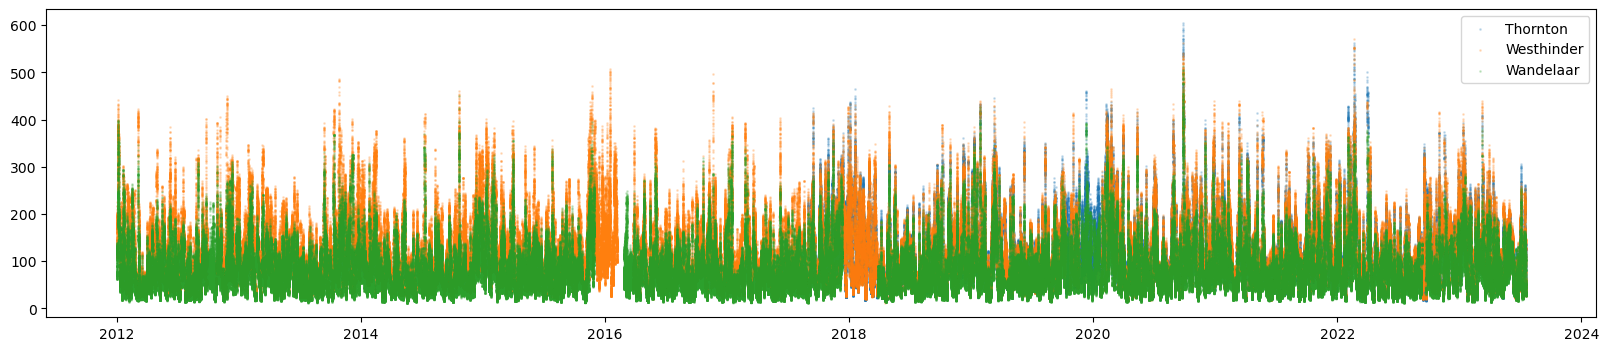

In [91]:
plt.figure(figsize=(20,4))
plt.scatter(Thorntonbank_data.index, Thorntonbank_data['mvbc_ThorntonbankSouthBuoy_Wave_height'], label='Thornton', s=1, alpha=0.2)
plt.scatter(Westhinder_data.index, Westhinder_data['mvbc_WesthinderBuoy_Wave_height'], label='Westhinder', s=1, alpha=0.2)
plt.scatter(weather_station_data.index, weather_station_data['mvbc_WandelaarBuoy_Wave_height'], label='Wandelaar', s=1, alpha=0.2)
plt.legend()
plt.show()

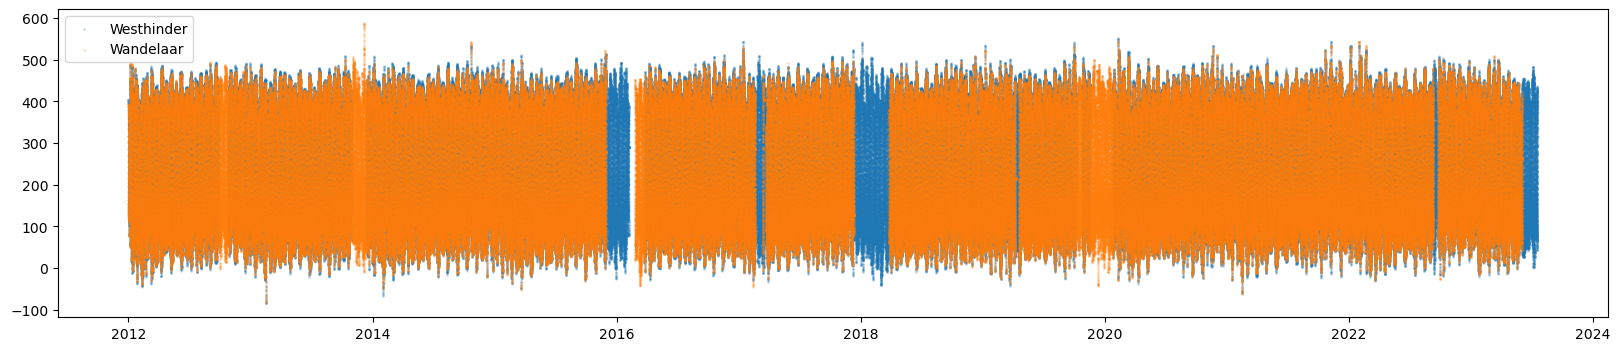

In [89]:
plt.figure(figsize=(20,4))
plt.scatter(Westhinder_data.index, Westhinder_data['mvbc_WesthinderMeasuringpile_Tide_TAW'], label='Westhinder', s=1, alpha=0.2)
plt.scatter(weather_station_data.index, weather_station_data['mvbc_WandelaarMeasuringpile_Tide_TAW'], label='Wandelaar', s=1, alpha=0.2)
plt.legend()
plt.show()

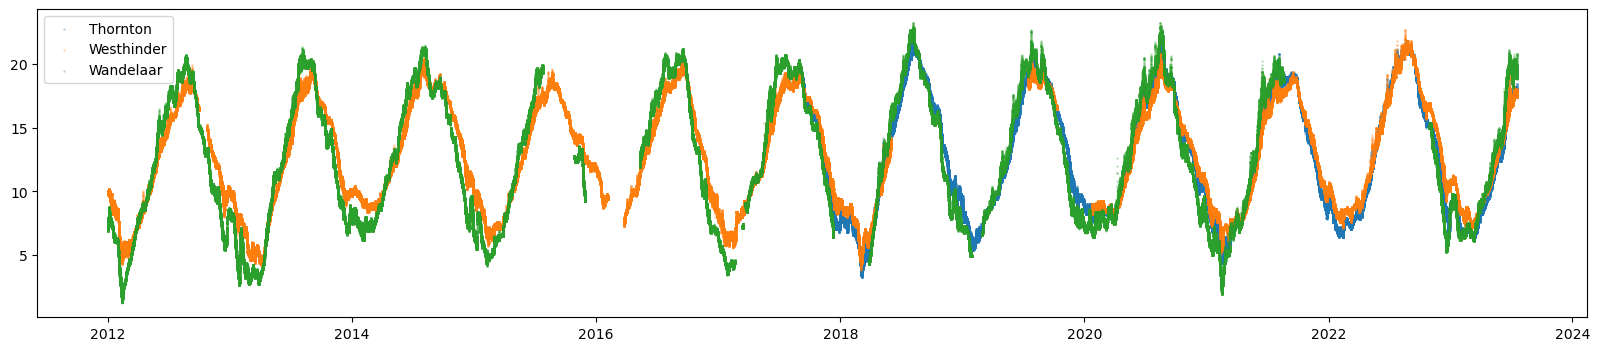

In [78]:
plt.figure(figsize=(20,4))
plt.scatter(Thorntonbank_data.index, Thorntonbank_data['mvbc_ThorntonbankSouthBuoy_Sea_water_temperature'], label='Thornton', s=1, alpha=0.2)
plt.scatter(Westhinder_data.index, Westhinder_data['mvbc_WesthinderBuoy_Sea_water_temperature'], label='Westhinder', s=1, alpha=0.2)
plt.scatter(weather_station_data.index, weather_station_data['mvbc_Wandelaar_Sea_water_temperature'], label='Wandelaar', s=1, alpha=0.2)
plt.legend()
plt.show()

In [85]:
weather_data.columns

Index(['mvbc_WandelaarBuoy_10%_highest_waves',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s',
       'mvbc_WandelaarMeasuringpile_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Average_wind_direction',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mvbc_WandelaarMeasuringpile_Flow_direction_cell_3',
       'mvbc_WandelaarBuoy_1%_wave_height',
       'mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Air_temperature',
       'mvbc_WandelaarBuoy_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Relative_humidity',
       'mvbc_Wandelaar_Sea_water_temperature'],
      dtype='object')

In [104]:
weatherstations_data['Westhinder'].filter(regex='Sea_water_temperature').isna().sum()

mvbc_WesthinderMeasuringpile_Sea_water_temperature    76766
mvbc_WesthinderBuoy_Sea_water_temperature             84796
dtype: int64

In [118]:
weather_data = weather_station_data.copy()
weatherstations_data = {'Westhinder': Westhinder_data, 'Thorntonbank': Thorntonbank_data}

weatherstations = ['Westhinder', 'Thorntonbank']
columns_impute = ['Sea_water_temperature', 'Tide_TAW', 'Wave_height', 'Average_wave_period']
for column in columns_impute:
    new_data = weather_data.filter(regex=column)
    if len(new_data.columns) > 1:
        #select columns with less nans
        kept_column = weather_data.filter(regex=column).isna().sum().sort_values().index[0]
        new_data = weather_data[kept_column]
    weather_data[column] = new_data
    for weatherstation in weatherstations:
        print(weatherstation, column)
        try:
            replacing_data = weatherstations_data[weatherstation].filter(regex=column)[weather_data[column].isna()]
            if len(replacing_data.columns) > 1:
                #select columns with less nans
                kept_column = replacing_data.isna().sum().sort_values().index[0]
            elif len(replacing_data.columns) == 1:
                kept_column = replacing_data.columns[0]
                print(kept_column)
            else:
                print('no data for weatherstation: ', weatherstation, ' and column: ', column)
                continue
            replacing_data = weatherstations_data[weatherstation][kept_column]
            weather_data.loc[weather_data[column].isna(), column] = replacing_data[weather_data[column].isna()]
            print('replaced')
        except:
            print('no data for weatherstation: ', weatherstation, ' and column: ', column)


Westhinder Sea_water_temperature
replaced
Thorntonbank Sea_water_temperature
mvbc_ThorntonbankSouthBuoy_Sea_water_temperature
replaced
Westhinder Tide_TAW
mvbc_WesthinderMeasuringpile_Tide_TAW
replaced
Thorntonbank Tide_TAW
no data for weatherstation:  Thorntonbank  and column:  Tide_TAW


C:\Users\Max\AppData\Local\Temp\ipykernel_23116\1525580656.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  replacing_data = weatherstations_data[weatherstation].filter(regex=column)[weather_data[column].isna()]
C:\Users\Max\AppData\Local\Temp\ipykernel_23116\1525580656.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  replacing_data = weatherstations_data[weatherstation].filter(regex=column)[weather_data[column].isna()]


Westhinder Wave_height
mvbc_WesthinderBuoy_Wave_height
replaced
Thorntonbank Wave_height
mvbc_ThorntonbankSouthBuoy_Wave_height
replaced
Westhinder Average_wave_period
mvbc_WesthinderBuoy_Average_wave_period
replaced
Thorntonbank Average_wave_period
mvbc_ThorntonbankSouthBuoy_Average_wave_period


C:\Users\Max\AppData\Local\Temp\ipykernel_23116\1525580656.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  replacing_data = weatherstations_data[weatherstation].filter(regex=column)[weather_data[column].isna()]
C:\Users\Max\AppData\Local\Temp\ipykernel_23116\1525580656.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  replacing_data = weatherstations_data[weatherstation].filter(regex=column)[weather_data[column].isna()]


replaced


In [119]:
weather_data.isna().sum()

mvbc_WandelaarBuoy_10%_highest_waves                                     30934
mvbc_WandelaarBuoy_Wave_height                                           30934
mvbc_WandelaarBuoy_Average_wave_period                                   31726
mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s                       38243
mvbc_WandelaarMeasuringpile_Sea_water_temperature                       291615
mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)    122115
mvbc_WandelaarMeasuringpile_Average_wind_direction                       39781
mvbc_WandelaarMeasuringpile_Tide_TAW                                     41799
mvbc_WandelaarMeasuringpile_Air_pressure                                 49001
mvbc_WandelaarMeasuringpile_Flow_direction_cell_3                       344615
mvbc_WandelaarBuoy_1%_wave_height                                       307142
mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)         122178
mvbc_WandelaarMeasuringpile_Air_temperature         

In [120]:
weather_data_path = "../../data/nw2/mvbc_data_longterm.parquet"

weather_data.to_parquet(weather_data_path, compression='gzip')